# Movie Data Collection, Pre-Processing and Feature Engineering

In [3]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from collections import defaultdict
import dateutil.parser
from pprint import pprint
import pandas
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from copy import deepcopy
import seaborn as sns
import urllib2, sys
import string
import gevent.monkey
gevent.monkey.patch_socket()
from gevent.pool import Pool
%matplotlib inline

### Helper methods for BeautifulSoup

In [4]:
def get_soup_ps(prefix, suffix):
    """Returns BeautifulSoup object given a prefix and suffix or a URL"""
    response = requests.get(prefix + suffix)   
    page = response.text
    soup = BeautifulSoup(page, 'html.parser')
    return soup

def get_soup_url(url):
    """Returns BeautifulSoup object given a URL"""
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, 'html.parser')
    return soup

### Helper methods to parse HTML and clean text

In [8]:
def get_movie_value(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text 
    else:
        next_sibling = obj.find_parent().findNextSibling()
        return next_sibling

    
def get_movie_values_odd(soup, field_name):
    '''Grabs value from boxofficemojo HTML in 
    Domestic Summary box
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    try:
        div_with_stats = soup.find_all('div',class_='mp_box_content')[1]
        flag = False
        obj = ''
        for element in div_with_stats.find_all('td'):
            if flag:
                obj = element.text
                return obj
            if field_name in str(element):
                flag = True
    except:
        return None

            
def get_weekly_rev(soup):
    '''Retrieves weekly revenue for given movie
    
    Returns a list of the weekly revenue,
    ordered by week since release
    '''
    try:
        weekly_rev_list = []
        for element in soup.find_all('center')[1]:
            box = element.find_all('font')
            for thing in box:
                if '$' in thing.text:
                    clean_num = money_to_int(thing.text)
                    weekly_rev_list.append(clean_num)
        if weekly_rev_list[0] == weekly_rev_list[1]:
            return weekly_rev_list[3::3]
        else:
            return weekly_rev_list[1::3]
    except:
        return None
    

def to_date(datestring):
    try:
        date = dateutil.parser.parse(datestring)
        return date
    except:
        return datestring
    

def money_to_int(moneystring):
    try:
        moneystring = moneystring.replace('$', '').replace(',', '')
        if 'mil' in moneystring:
            moneystring_digits = moneystring.split(' ')[0].strip()
            return int(moneystring_digits) * 1000000
        return int(moneystring)
    except:
        return None
    
    
def runtime_to_minutes(runtimestring):
    try:
        runtime = runtimestring.split()
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

    
def theaters_to_int(theaterstring):
    try:
        theaters = int(str(theaterstring.split()[0]).replace(',',''))
        return theaters
    except:
        return None


def release_time_to_days(releasestring):
    try:
        days = int(releasestring.split()[0])
        return days
    except:
        return None

## Scrape Movie Data from BoxOfficeMojo.com

First, get a list of all of the links to individual movie pages from the 'Top Movies of All Time' list on Box Office Mojo.

In [6]:
movie_prefix = 'http://www.boxofficemojo.com/alltime/domestic.htm?page=' 
partial_movie_suffix = '&p=.htm'
top_movie_links = set()

for page in range(1,41):
    full_movie_suffix = str(page) + partial_movie_suffix
    soup = get_soup_ps(movie_prefix, full_movie_suffix)
    for element in soup.find_all('a'):
        link = element.get('href')
        if link.startswith('/movies/?id'):
            top_movie_links.add(link)
    # Fix edge case
    if '/movies/?id=michelledarnell.htm' in top_movie_links:
        top_movie_links.remove('/movies/?id=michelledarnell.htm')

Number of movie links

In [7]:
len(top_movie_links)

3903


Extract relevant info from each movie page and store in a nested dictionary

In [ ]:
headers = ['movieid','movie title', 'domestic total gross',
           'release date', 'runtime (mins)', 'rating', 
           'genre', 'production budget', 'distributor',
            'opening weekend revenue', 'number of theaters',
            'time in theaters (days)']

base_url = 'http://www.boxofficemojo.com/'

movie_data = []
rev_data = {}
missing_links = []

counter = 1

for movie in list(top_movie_links):
    try:
        # Create a movieid
        movieid = counter
        counter += 1

        # Create dictionary of movieid to list of weekly revenues
        movie_link_split = movie.split('?')
        weekly_suffix = movie_link_split[0] + '?page=weekly&' + movie_link_split[1]
        weekly_soup = get_soup_ps(base_url, weekly_suffix)

        weekly_revenue = get_weekly_rev(weekly_soup)

        rev_data[movieid] = weekly_revenue


        # Create list of movie data dictionarys
        soup = get_soup_ps(base_url, movie)
        adj_soup = get_soup_ps(base_url, movie + '&adjust_yr=2016&p=.htm')
        # Title
        raw_title_string = soup.find('title').text
        title = raw_title_string.split('(')[0].strip()
        # Release Date
        raw_release_date = get_movie_value(soup,'Release Date')
        release_date = to_date(raw_release_date)
        # Total Domestic Gross Revenue
        raw_domestic_total_gross = get_movie_value(adj_soup,'Domestic Total')
        domestic_total_gross = money_to_int(raw_domestic_total_gross)
        # Runtime
        raw_runtime = get_movie_value(soup,'Runtime')
        runtime = runtime_to_minutes(raw_runtime)
        # Rating
        rating = get_movie_value(soup,'MPAA Rating')
        # Genre
        genre = get_movie_value(soup, 'Genre:')
        # Production Budget
        raw_prod_budget = get_movie_value(soup, 'Production Budget')
        prod_budget = money_to_int(raw_prod_budget)
        # Distributor
        distributor = get_movie_value(soup, 'Distributor:')
        # Opening Weekend Revenue
        raw_opening_weekend = get_movie_values_odd(adj_soup, 'Opening')
        opening_weekend = money_to_int(raw_opening_weekend)
        # Number of Theaters at Widest Release
        raw_widest_release = get_movie_values_odd(soup, 'Widest')
        widest_release = theaters_to_int(raw_widest_release)
        # Number of Days in Theaters
        raw_realease_time = get_movie_values_odd(soup, 'In Release')
        release_time = release_time_to_days(raw_realease_time)
        # Close Date
        raw_close_date = get_movie_values_odd(soup, 'Close')
        close_date = to_date(raw_close_date)

        # Calculate days in theaters if not given
        if release_time == None and close_date != None:
            day_diff = close_date - release_date
            release_time = release_time_to_days(str(day_diff))
        elif release_time == None and close_date == None and weekly_revenue != None:
            num_weeks = len(weekly_revenue)
            release_time = num_weeks * 7


        movie_dict = dict(zip(headers, [movieid, 
                                        title,
                                        domestic_total_gross,
                                        release_date,
                                        runtime,
                                        rating,
                                        genre,
                                        prod_budget,
                                        distributor,
                                        opening_weekend,
                                        widest_release,
                                        release_time]))

        movie_data.append(movie_dict) 
    
    except:
        print 'ChunkedEncodingError'
        missing_links.append(movie)

Here is a sample of the output. **rev_data** is a dictionary where the key is a movie's id and the value is that movies weekly box office revenue. **movie_data** is a list of dictionary where each dictionary contains information on a single movie.

In [27]:
test_rev_data = {k: rev_data[k] for k in rev_data.keys()[:10]}
print (test_rev_data)
print (movie_data[:10])

{1: [4934, 5692, 5092, 3050, 2618, 1822, 1592, 1251], 2: [10639, 9349, 9011, 7849, 5817, 4080, 3556, 2798, 1903, 1726], 3: [5325, 2944, 1842, 1211, 759, 763, 607, 465, 430, 397, 420, 485, 691, 480, 421], 4: [6324, 3495, 2855, 1455, 1200, 1055, 650, 605, 580], 5: [7924, 5851, 3130, 2759, 4243, 3014, 2248, 1730, 1349, 1196], 6: [43292, 41573, 5905, 4385, 3507, 3075, 2329], 7: [7709, 4813, 2411, 1659, 1120, 930, 794, 659, 2182, 1192, 1008, 1519, 1022, 1548], 8: [2181, 2530, 1190, 1172], 9: [7463, 6550, 7799, 5877, 3927, 2917, 2316, 1860, 1667], 10: [12665, 7955, 4965, 2985, 2017, 1999, 1181, 1037]}
[{'rating': u'PG', 'time in theaters (days)': 56, 'movieid': 1, 'production budget': None, 'domestic total gross': 90944400, 'number of theaters': 1515, 'opening weekend revenue': 8129500, 'distributor': u'Orion Pictures', 'movie title': u'Dirty Rotten Scoundrels', 'genre': u'Comedy', 'release date': datetime.datetime(1988, 12, 16, 0, 0), 'runtime (mins)': 110}, {'rating': u'R', 'time in theate

Pickle if necessary

In [ ]:
with open('movie_data.pickle', 'wb') as handle:
    pickle.dump(movie_data, handle)

with open('rev_data.pickle', 'wb') as handle:
    pickle.dump(movie_data, handle)

## Clean movie data and create / select features

Add movie data to pandas dataframe

In [32]:
moviedf = pd.DataFrame(movie_data)

Check data types

In [33]:
moviedf.dtypes

distributor                        object
domestic total gross              float64
genre                              object
movie title                        object
movieid                             int64
number of theaters                float64
opening weekend revenue           float64
production budget                 float64
rating                             object
release date               datetime64[ns]
runtime (mins)                    float64
time in theaters (days)           float64
dtype: object


Count number of non-zero entries for each feature

In [34]:
moviedf.count(axis=0)

distributor                3900
domestic total gross       3900
genre                      3900
movie title                3903
movieid                    3903
number of theaters         3632
opening weekend revenue    3297
production budget          2025
rating                     3900
release date               3900
runtime (mins)             3899
time in theaters (days)    3654
dtype: int64

Look at description of numerical features

In [36]:
moviedf.describe()

,domestic total gross,movieid,number of theaters,opening weekend revenue,production budget,runtime (mins),time in theaters (days)
count,3.900000e+03,3903.000000,3632.000000,3.297000e+03,2.025000e+03,3899.000000,3654.000000
mean,9.625383e+07,1952.000000,2230.817181,2.354510e+07,5.487065e+07,108.427289,93.705255
std,9.894027e+07,1126.843379,933.700176,2.306523e+07,4.632437e+07,19.376241,175.692769
min,1.263930e+07,1.000000,2.000000,4.960000e+04,1.500000e+04,38.000000,0.000000
25%,3.758938e+07,976.500000,1489.750000,1.054660e+07,2.200000e+07,95.000000,42.000000
50%,6.257970e+07,1952.000000,2292.500000,1.649820e+07,4.000000e+07,106.000000,77.000000
75%,1.153584e+08,2927.500000,2950.000000,2.766540e+07,7.500000e+07,118.000000,112.000000
max,1.239014e+09,3903.000000,4468.000000,2.479667e+08,3.000000e+08,227.000000,4697.000000


Rename columns

In [ ]:
moviedf = moviedf.rename(columns={'distributor':'dist', 'domestic total gross': 'dom_tot_gross',
                        'movie title': 'title', 'number of theaters': 'num_theaters',
                        'opening weekend revenue': 'open_rev', 'production budget': 
                        'budget', 'release date': 'release', 'runtime (mins)': 'runtime',
                        'time in theaters (days)': 'time_theaters', 'release month': 'month',
                        'decay rate': 'decay'})

Notice how 'time in theaters' contains some abnormally large numbers. Checking which movies were in theaters for over 500 days shows us these are mostly IMAX movies, likely showing in special theaters (i.e. at museums).

In [37]:
moviedf[moviedf['time in theaters (days)'] > 500]

,distributor,domestic total gross,genre,movie title,movieid,number of theaters,opening weekend revenue,production budget,rating,release date,runtime (mins),time in theaters (days)
28,Warner Bros.,40405900.0,IMAX,Under the Sea 3D,29,108.0,771100.0,NaN,G,2009-02-13,40.0,2310.0
490,Sony Classics,22447900.0,IMAX,Across the Sea of Time,491,2.0,NaN,NaN,G,1995-10-20,51.0,3142.0
666,Warner Bros.,15663600.0,IMAX,To the Arctic,667,52.0,289500.0,NaN,G,2012-04-20,40.0,1127.0
792,IMAX,126001600.0,IMAX,Space Station 3-D,793,64.0,733000.0,NaN,Unrated,2002-04-19,46.0,4697.0
1105,Sony Classics,24348500.0,IMAX,Cirque du Soleil: Journey of Man,1106,22.0,80400.0,NaN,G,2000-05-05,38.0,1402.0
1187,WGB.,23353700.0,IMAX,Shackleton's Antarctic Adventure,1188,26.0,NaN,NaN,G,2001-02-10,40.0,1034.0
1229,IMAX,82589700.0,IMAX,T-Rex: Back to the Cretaceous,1230,38.0,NaN,NaN,Unrated,1998-10-23,45.0,3234.0
1317,IMAX,26204200.0,IMAX,Galapagos,1318,14.0,NaN,NaN,Unrated,1999-10-29,40.0,3794.0
1621,Buena Vista,24491000.0,IMAX,Ghosts of the Abyss,1622,97.0,2032100.0,NaN,G,2003-04-11,61.0,917.0
1664,Warner Bros.,57619400.0,IMAX,Deep Sea 3D,1665,47.0,930100.0,NaN,G,2006-03-03,40.0,2842.0


Flatten the genres into only 8 genre buckets

In [51]:
genre_dict = {'War Romance':'Drama', 'Horror Thriller':'Horror / Thriller', 'Period Drama':'Drama',
              'Music Drama':'Drama','Romantic Comedy':'Comedy', 'Action Drama':'Drama',
              'Sci-Fi Action': 'Action', 'Action / Adventure': 'Action', 'Fantasy': 'Sci-Fi',
              'Drama / Thriller': 'Drama', 'Sports Drama':'Drama', 'Horror': 'Horror / Thriller',
              'Action Thriller': 'Action', 'Action Comedy':'Comedy','Family Adventure':'Family', 
              'War':'Drama', 'Crime Comedy':'Comedy', 'Family Comedy':'Family', 'Comedy / Drama': 'Comedy',
              'Romantic Thriller':'Horror / Thriller', 'Thriller':'Horror / Thriller', 
              'Fantasy Comedy':'Comedy','Sci-Fi Horror':'Horror / Thriller', 'Fantasy Drama':'Drama', 
              'Sports Comedy':'Comedy', 'Sci-Fi Thriller':'Sci-Fi','Comedy Thriller':'Comedy', 'Horror Comedy':'Comedy',
              'Romance':'Drama', 'Period Action':'Action','Foreign / Action':'Action', 'IMAX':'Documentary', 
              'War Drama':'Drama', 'Crime Drama':'Drama', 'Action Horror':'Horror / Thriller', 'Western':'Action', 
              'Musical':'Drama', 'Sci-Fi Adventure':'Sci-Fi', 'Action / Crime':'Action', 'Crime Thriller':'Horror / Thriller',
              'Period Adventure':'Drama', 'Historical Drama':'Drama', 'Sci-Fi Comedy':'Comedy', 'Western Comedy':'Comedy',
              'Foreign / Horror':'Horror / Thriller', 'Action Fantasy':'Action', 'Crime':'Drama', 'Sports Action':'Action',
              'Period Horror':'Horror / Thriller', 'Historical Epic':'Drama', 'Adventure Comedy':'Comedy',
              'Adventure':'Action', 'Foreign':'Drama', 'Period Comedy':'Comedy', 'Romantic Adventure':'Drama', 
              'Concert':'Documentary', 'Sci-Fi Fantasy': 'Sci-Fi'}

In [52]:
moviedf = moviedf.replace({'genre' : genre_dict})

### Add features

Create a column containing only the release month instead of the entire date

In [38]:
moviedf['release month'] = moviedf['release date'].dt.month

In [39]:
moviedf.head()

,distributor,domestic total gross,genre,movie title,movieid,number of theaters,opening weekend revenue,production budget,rating,release date,runtime (mins),time in theaters (days),release month
0,Orion Pictures,90944400.0,Comedy,Dirty Rotten Scoundrels,1,1515.0,8129500.0,NaN,PG,1988-12-16,110.0,56.0,12.0
1,Fox,252358600.0,Action Thriller,Speed,2,2169.0,30088300.0,30000000.0,R,1994-06-10,116.0,70.0,6.0
2,Paramount,48884600.0,Comedy,The Out-of-Towners,3,2128.0,14084800.0,75000000.0,PG-13,1999-04-02,90.0,105.0,4.0
3,Universal,39263600.0,War Romance,Captain Corelli's Mandolin,4,1612.0,11081500.0,57000000.0,R,2001-08-17,129.0,63.0,8.0
4,Paramount,108640100.0,Comedy,"Planes, Trains and Automobiles",5,1684.0,15596500.0,NaN,R,1987-11-25,92.0,70.0,11.0


## Clean revenue data and add features

Add revenue data to a pandas dataframe

In [4]:
with open('pickles/rev_data3.pickle', 'rb') as handle:
    rev_data = pickle.load(handle)

In [5]:
revdf = pd.DataFrame.from_dict({k : pd.Series(v) for k,v in rev_data.items()}, 
                                     orient='index')

In [6]:
revdf.head()

,0,1,2,3,4,5,6,7,8,9,...,661,662,663,664,665,666,667,668,669,670
1,4934,5692.0,5092.0,3050.0,2618.0,1822.0,1592.0,1251.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10639,9349.0,9011.0,7849.0,5817.0,4080.0,3556.0,2798.0,1903.0,1726.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5325,2944.0,1842.0,1211.0,759.0,763.0,607.0,465.0,430.0,397.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6324,3495.0,2855.0,1455.0,1200.0,1055.0,650.0,605.0,580.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7924,5851.0,3130.0,2759.0,4243.0,3014.0,2248.0,1730.0,1349.0,1196.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Convert all the revenue numbers to floats

In [ ]:
rev_list = []
iterator = revdf.iterrows()
for item in iterator:
    num_list = []
    for num in item[1]:
        money = money_to_int(str(num))
        num_list.append(money)
    rev_list.append(num_list)

In [11]:
revdf = pd.DataFrame(rev_list, index=revdf.index)

Get rid of all movies with no data

In [ ]:
revdf = revdf[revdf.isnull().all(axis=1)]

Get the movieid's for the remaining movies and remove any movies that had no revenue data from the movie dataframe

In [ ]:
movieid_list = revdf.index.tolist()
moviedf = moviedf[moviedf.index.isin(index_list)]

Calculate the decay rate of weekly revenue for each movie. Decay rate is defined as follows:<br/>
decay rate = ( ln(last week's revenue) - ln(max revenue) ) / num_weeks_btw_last_and_max

In [91]:
ittr = revdf.iterrows()

decay_rates = []
for row in ittr:
    rev_series = row[1]
    # Use the maximum 
    a = rev_series.max()
    a_index = rev_series.idxmax()
    num_weeks = rev_series.count()
    t = rev_series.count() - a_index - 1
    y = rev_series[num_weeks - 1]
    k = (np.log(y) - np.log(a)) / t
    decay_rates.append(k)

In [92]:
print decay_rates[:10]

[-0.25251974145713846, -0.20207998909699912, -0.18125251120680325, -0.29863488684861217, -0.21010149703420725, -0.48708814492178271, -0.12349420786996841, -0.38475380579230434, -0.25716165276328384, -0.35750147917232106]


Add decay rates to revenue dataframe

In [93]:
revdf['decay rate'] = np.asarray(decay_rates)

In [94]:
revdf.head()

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,decay rate
1,4934,5692.0,5092.0,3050.0,2618.0,1822.0,1592.0,1251.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.252520
2,10639,9349.0,9011.0,7849.0,5817.0,4080.0,3556.0,2798.0,1903.0,1726.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.202080
3,5325,2944.0,1842.0,1211.0,759.0,763.0,607.0,465.0,430.0,397.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.181253
4,6324,3495.0,2855.0,1455.0,1200.0,1055.0,650.0,605.0,580.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.298635
5,7924,5851.0,3130.0,2759.0,4243.0,3014.0,2248.0,1730.0,1349.0,1196.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.210101


Next, I chose to remove movies where there are over 100 weeks of revenue as these are outliers and may skew the outcome

In [13]:
revdf = revdf[revdf.count(axis=1) < 100]

Now add the decay rate to the movie data frame to use as our independant variable

In [96]:
decaydf = pd.DataFrame(revdf['decay rate'], index=revdf.index)
decaydf.head()

,decay rate
1,-0.252520
2,-0.202080
3,-0.181253
4,-0.298635
5,-0.210101


In [109]:
moviedf = pd.merge(moviedf, decaydf, left_on='movieid', right_index=True, how='inner')
moviedf.head()

,dist,dom_tot_gross,genre,title,movieid,num_theaters,open_rev,budget,rating,release,runtime,time_theaters,month,meta_rating,rating_bin,decay rate
0,Orion Pictures,90944400.0,Comedy,Dirty Rotten Scoundrels,1,1515.0,8129500.0,NaN,PG,1988-12-16,110.0,56.0,12.0,68,"(60.4, 80.2]",-0.252520
1,Fox,252358600.0,Action,Speed,2,2169.0,30088300.0,30000000.0,R,1994-06-10,116.0,70.0,6.0,78,"(60.4, 80.2]",-0.202080
2,Paramount,48884600.0,Comedy,The Out-of-Towners,3,2128.0,14084800.0,75000000.0,PG-13,1999-04-02,90.0,105.0,4.0,33,"(20.8, 40.6]",-0.181253
3,Universal,39263600.0,Drama,Captain Corelli's Mandolin,4,1612.0,11081500.0,57000000.0,R,2001-08-17,129.0,63.0,8.0,36,"(20.8, 40.6]",-0.298635
4,DreamWorks,55006600.0,Comedy,Head of State,7,2256.0,19482600.0,NaN,PG-13,2003-03-28,95.0,112.0,3.0,44,"(40.6, 60.4]",-0.123494


Get rid of movies where decay rate is above 0

In [54]:
moviedf = moviedf[moviedf['decay rate'] < 0]

## Scrape MetaCritic data
With a goal of predicting the decay rate of a movie's box office revenue, it seemed important to include a feature that measured the quality of the movie. I chose to scrape MetaCritic for movie ratings (1-100). <br/><br/>
Below are some helper functions. Note that all of them may not be used. 

In [4]:
def get_meta_url_list():
    """
    Finds the URL of the movie page for all movies on MetaCritis and
    returns the URL's as a list.
    """
    url_list = []
    meta_base = 'http://www.metacritic.com/browse/movies/title/dvd' 
    alpha = [''] + list(string.ascii_lowercase)
    for letter in alpha:
        url = meta_base + '/' + letter + '?view=condensed'
        url_list.append(url)
        pages = np.arange(1,20)
        for pg in pages: 
            url = meta_base + '/' + letter + '?view=condensed&page=' + str(pg)
            url_list.append(url)
    return url_list

def get_soup_url(url):
    """
    Given a URL, returns a soup object using 'requests.'
    """
    hdr = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=hdr)
    page = response.text
    soup = BeautifulSoup(page, 'xml')
    return soup

def get_soup_meta(url):
    """
    Given a URL, returns a soup objects using 'urllib2.'
    """
    hdr = {'User-Agent': 'Mozilla/5.0'}
    req = urllib2.Request(url,headers=hdr)
    page = urllib2.urlopen(req)
    soup = BeautifulSoup(page)
    return soup

def get_soups(url_list):
    """
    Given a list of URL's, returns a list of soups using gevent's pool
    for increased speed.
    """
    pool = Pool(25)
    soup_list = []
    faulty_url_list = []
    for link in url_list:
        soup_list.append(pool.spawn(get_soup_url, link))
    pool.join()
    return soup_list

def get_meta_rating_moviepg(soup):
    """
    Given a soup, finds the title and rating of the movie.
    """
    name_not_found = True
    for item in soup.find_all('span'): 
        if item.get('itemprop') == 'ratingValue':
            rating = item.text.strip()
        if item.get('itemprop') == 'name' and (name_not_found):
            title = item.text.strip()
            name_not_found = False
    return title, rating

Test code for a single movie page

In [5]:
meta_url = 'http://www.metacritic.com/movie/philadelphia'
soup = get_soup_meta(meta_url)
title, rating = get_meta_rating_moviepg(soup)
print title, rating

Philadelphia 66


/Users/MelanieAppleby/anaconda/envs/benson/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Retrieve the list of all movie URLs on MetaCritic

In [ ]:
url_list = get_meta_url_list()

Get the soups for each URL

In [ ]:
soup_list = []
for url in url_list:
    soup = get_soup_meta(url)
    soup_list.append(soup)

Find the title and rating of a movie given its soup

In [ ]:
meta_ratings_dict = {}

for soup in soup_list:
    for movie in soup.find_all('div', class_='basic_stat product_score brief_metascore'):
        rating = movie.text.strip()
        parent = movie.find_parent('div')
        title = parent.find(class_='basic_stat product_title').text.strip()
        meta_ratings_dict[title] = rating

Add this dictionary to a pandas series 

In [22]:
ratings = pd.Series(meta_ratings_dict)
ratings.head()

#Horror    42
$9.99      68
$pent      34
'71        83
'R Xmas    55
dtype: object

And then add it to a dataframe, using the movie title as the index

In [26]:
ratingsdf = pd.DataFrame(ratings, index=ratings.index, columns = ['meta_rating'])
ratingsdf.head()

,meta_rating
#Horror,42
$9.99,68
$pent,34
'71,83
'R Xmas,55


Add this rating data to the main moviedf

In [ ]:
moviedf = pd.merge(moviedf, ratingsdf, left_on='movie title', right_index=True, how='left')

Get rid of any movies where the Metacritic rating is null and then check the counts of all the features

In [38]:
moviedf = moviedf[pd.notnull(moviedf['meta_rating'])]
moviedf.count(axis=0)

distributor                2475
domestic total gross       2475
genre                      2475
movie title                2475
movieid                    2475
number of theaters         2469
opening weekend revenue    2183
production budget          1703
rating                     2475
release date               2475
runtime (mins)             2474
time in theaters (days)    2475
release month              2475
decay rate                 2475
meta_rating                2475
dtype: int64

Create a column that bins the MetaCritic rating into 5 bins. 

In [ ]:
ratings_bin, bins = pd.cut(moviedf['meta_rating'], 5, retbins=True)
moviedf['rating_bin'] = ratings_bin

## Visualize Data

First, let's look at the distribution of each numerical feature using KDE

In [15]:
def plot_kde(df, category):
    """Given a dataframe and column name, plots the kernal density estimation"""
    dropped = df[category].dropna()
    density = gaussian_kde(dropped)
    xs = np.linspace(dropped.min(),dropped.max(),300)
    ys = density(xs)
    plt.plot(xs, ys)
    plt.title('PDF of ' + category)
    plt.ylabel('Probability')
    plt.xlabel(category)

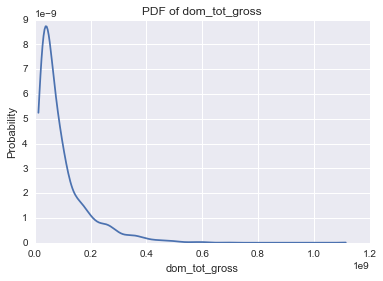

In [21]:
plot_kde(moviedf, 'dom_tot_gross')

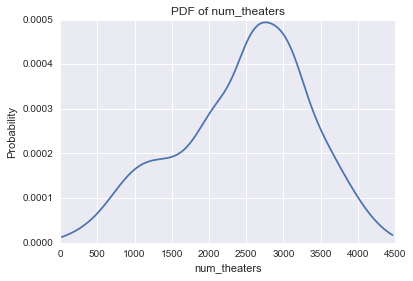

In [22]:
plot_kde(moviedf, 'num_theaters')

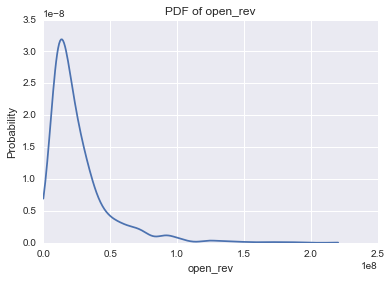

In [23]:
plot_kde(moviedf, 'open_rev')

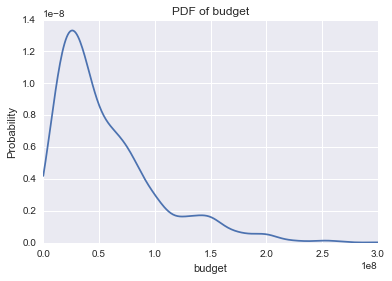

In [24]:
plot_kde(moviedf, 'budget')

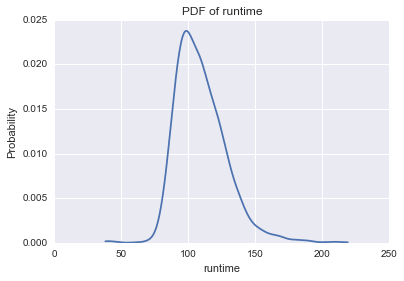

In [25]:
plot_kde(moviedf, 'runtime')

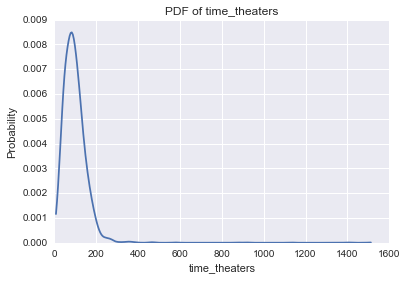

In [26]:
plot_kde(moviedf, 'time_theaters')

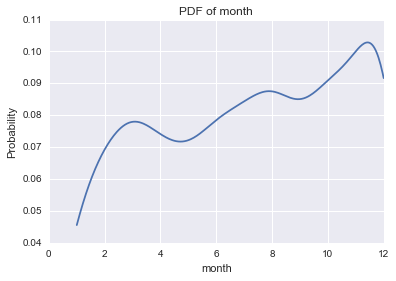

In [28]:
plot_kde(moviedf, 'month')

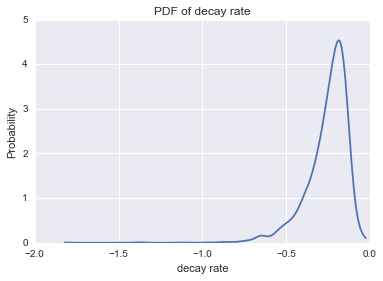

In [30]:
plot_kde(moviedf, 'decay rate')

Next, let's look at the distribution of categorical features using histograms

In [33]:
def plot_bar(df, column):
    ys = df[column].value_counts(normalize=True, sort=False)
    xs = np.arange(len(ys))
    plt.figure(figsize=(18,5))
    plt.bar(xs, ys.values)
    plt.xticks(xs, ys.index, rotation=45, size=17)

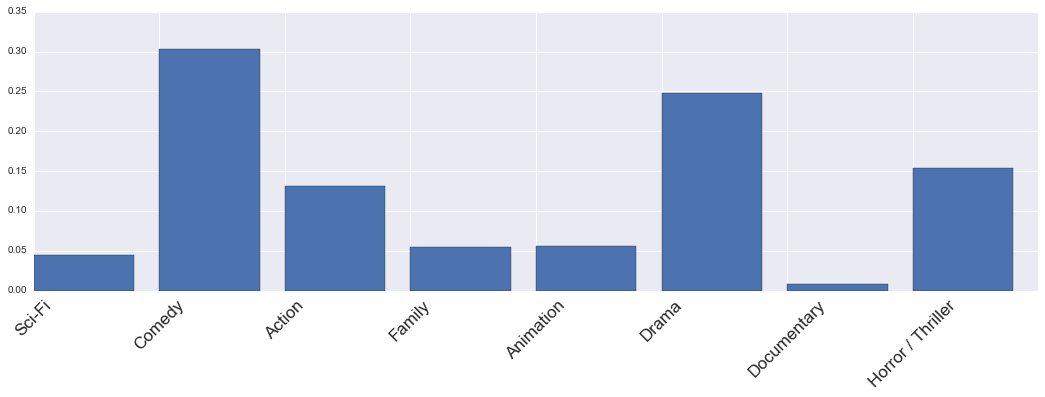

In [34]:
plot_bar(moviedf, 'genre')

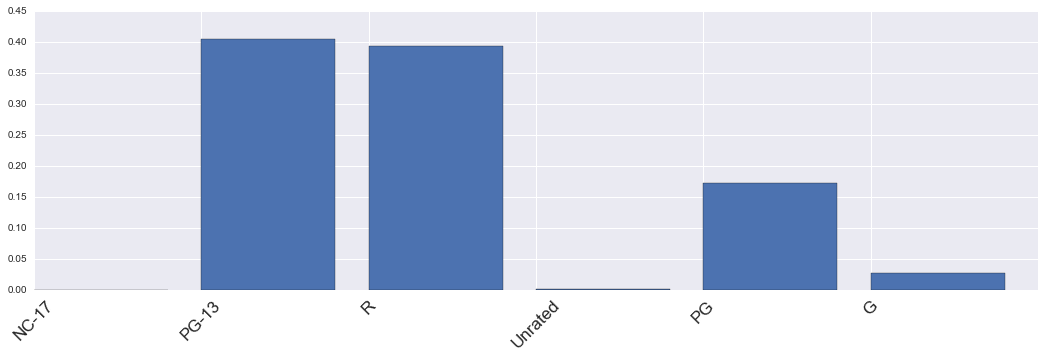

In [35]:
plot_bar(moviedf, 'rating')

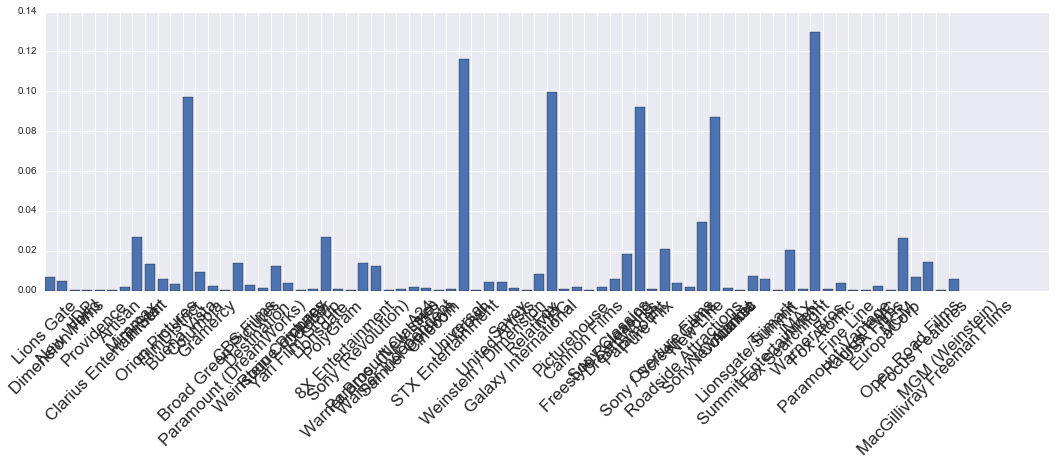

In [37]:
plot_bar(moviedf, 'dist')

Next, let's look at a scatter plot of all of the features vs. our independent variable, decay rate

In [38]:
def plot_scatter(df, category):
    xs = df[category]
    ys = df['decay rate']
    plt.scatter(xs, ys)
    plt.savefig('img/scatter'+category+'.png')

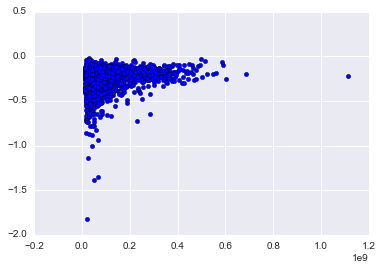

In [39]:
plot_scatter(moviedf, 'dom_tot_gross')

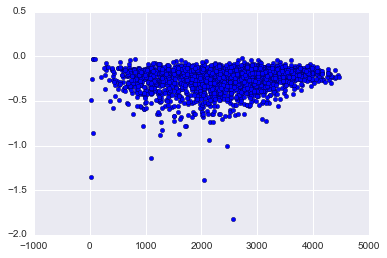

In [40]:
plot_scatter(moviedf, 'num_theaters')

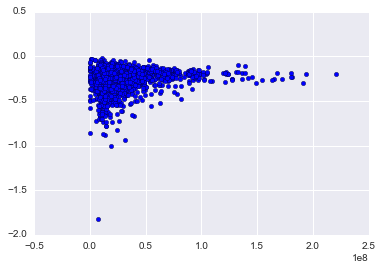

In [42]:
plot_scatter(moviedf, 'open_rev')

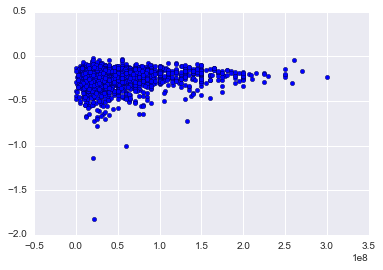

In [43]:
plot_scatter(moviedf, 'budget')

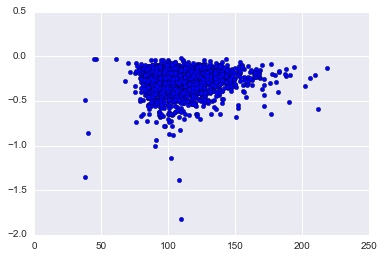

In [44]:
plot_scatter(moviedf, 'runtime')

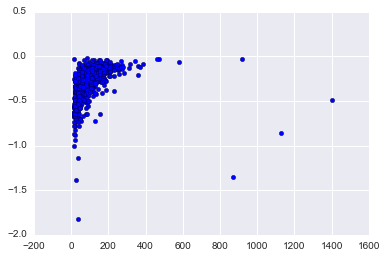

In [46]:
plot_scatter(moviedf, 'time_theaters')

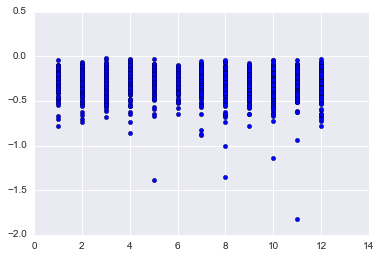

In [45]:
plot_scatter(moviedf, 'month')

Now let's look at a scatter plot for all the categorical features

In [47]:
def plot_scatter_categorical(df, category):
    d = {}
    i = 0
    for c in df[category].unique():
        d[c] = i
        i += 1
    copy = df.copy(deep=True)
    copy[category + '_cat'] = copy[category].map(d)
    xs = copy[category + '_cat']
    ys = copy['decay rate']
    plt.scatter(xs, ys)

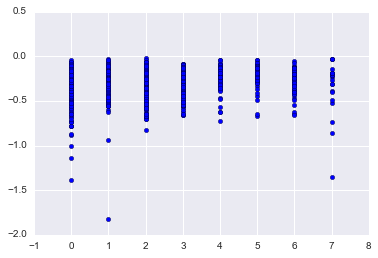

In [48]:
plot_scatter_categorical(moviedf, 'genre')

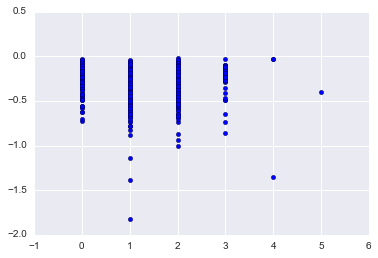

In [49]:
plot_scatter_categorical(moviedf, 'rating')

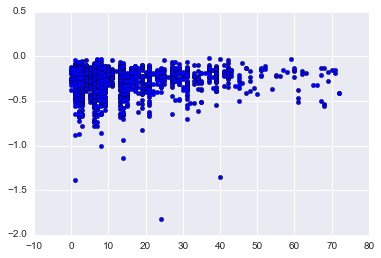

In [50]:
plot_scatter_categorical(moviedf, 'dist')